<a href="https://colab.research.google.com/github/julwalzajjj/BMSTUtasks/blob/main/RS_L4_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача А: персональные рекомендации

## Формулировка задачи

Необходимо на основе заказов пользователей сформировать предложение для его последующих покупок. Релевантность рекомендации будет оцениваться исходя из последующих покупок пользователей и того, насколько хорошо алгоритм позволяет их предсказать.

In [2]:
!pip install scann

In [ ]:
!pip install rank_bm25

In [3]:
!pip install feature_engine

In [ ]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.9 MB/s eta 0:00:00


In [4]:
!pip install tqdm

In [ ]:
!pip install xlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=225749 sha256=e31f6152f9b39941df625e3b29ac58f76728f4d363a4180f580d44623c61f91a
  Stored in directory: /root/.cache/pip/wheels/09/48/04/779ee06b22532c86cde8da8984b83284517492dad1df998c6a
Successfully built xlearn


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
# import faiss
import random
import scann

from tqdm import notebook, tqdm

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from feature_engine.creation import CyclicalFeatures

from gensim.models import Word2Vec

# import xlearn as xl
# # from xlearn import DMatrix

# import catboost as cb

from sklearn.datasets import dump_svmlight_file

# from rank_bm25 import BM25Okapi
# from itertools import chain

In [6]:
import seaborn as sns

In [7]:
from scipy.stats import norm

In [8]:
RANDOM_STATE=34

## L3 Формирование обучающей выборки, проектирование валидации

Итог: сформирована обучающая, тестовая и валидационная выборки, построен пайплайн валидации

План:

- [x] Cleaning: критерий Граббса
- [x] Feature Engeneering
    1. [x] Обучение эмбеддингов
    2. [x] Дополнительные признаки
- [x] Извлечение
- [x] Ранжирование
    1. [x] Формирование таргета
    2. [x] Фильтрация
    3. [x] Ранжирование
- [ ] Оценка предсказания
- [ ] Feature importance (?)
- [ ] Кросс-валидация

In [9]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/wb_school_task_1.csv.gzip", compression='gzip')
except:
    data = pd.read_csv(r"C:\Users\User\Documents\wildberries\wb_school_task_1.csv.gzip", compression='gzip')

Mounted at /content/drive


### Формирование выборок

Для формирования рекомендаций необходимо разделить данные на тренировочную и тестовую выборку (будем проводить кросс-валидацию):

Нужно отсортировать данные по времени покупок, чтобы в тестовой выборке были наиболее новые. В рекомендательных системах разделение происходит таким образом. Также для формирования эмбеддингов это необходимо.

In [10]:
sorted_data = data.sort_values(by=['order_ts']).reset_index(drop=True)

In [11]:
sorted_data['order_ts'] = pd.to_datetime(sorted_data['order_ts'])

In [12]:
train = sorted_data[sorted_data['order_ts'].dt.month != 3]

In [13]:

test = sorted_data[sorted_data['order_ts'].dt.month == 3]

Из тестовой (валидационной) выборки будем брать **список покупок** определенного пользователя.

![image.png](attachment:image.png)

### Обработка выбросов

Обработка выбросов происходит по критерию Граббса с экспериментальными значениями процентов выбросов, по умолчанию значения установлены, их можно будет поменять. Для нашего датасета отчищение выбросов методами `KNN` и `IsolationForest` слишком долгие (около 3-ех минут для 1/5 части).

Применяется функция `CleaningOutliners`, приведены значения, сделанные по выводам обработки выбросов на этапе L1:

In [14]:
def outlinersGrubbs(data, column, percent):
    df = data.copy()
    df['g_score'] = np.abs(df[column] - df[column].mean()) / df[column].std()
    df['p_value'] = 2 * norm.sf(abs(df['g_score']))
    return df.sort_values(by='p_value', ascending=True).head(round(df.shape[0]*percent/100))

def multiInd(x):
    indexes = list(x.index)
    first_col = []
    second_col = []
    for row in indexes:
        first_col.append(row[1])
        second_col.append(row[0])
    return first_col, second_col

# CleaningOutliners
# input: data - датасет,
#        p1 - процент выбросов для больших заказов,
#        p2 - процент выбросов для количества заказов у пользователя,
#        p3 - процент выбросов для заказов с одинаковыми товарами,
#        p4 - процент выбросов для активных юзеров,
#        p5 - процент выбросов для популярных товаров,
# otput: df - отчищенный датасет

def CleaningOutliners(data, p1=0.002, p2=0.01, p3=0.001, p4=0.02, p5=0.05):

    df = data.copy()

    orders = df.groupby(['order_ts', 'user_id']).count()
    orders_out = outlinersGrubbs(orders, 'item_id', p1)
    users_bg_orders, dates_bg_orders = multiInd(orders_out)
    df = df[~(df['user_id'].isin(users_bg_orders) & df['order_ts'].isin(dates_bg_orders))]

    cnt_orders = df.drop(['item_id'], axis=1).drop_duplicates().groupby(['user_id']).count()
    cnt_orders_out = outlinersGrubbs(cnt_orders, 'order_ts', p2)
    df = df[~(df['user_id'].isin(cnt_orders_out.index))]

    duplicated_items = df[df.duplicated()].value_counts().sort_values(ascending=False)
    duplicated_items = pd.DataFrame(duplicated_items, columns=['items_cnt'])
    duplicated_items_out = outlinersGrubbs(duplicated_items, 'items_cnt', p3)
    items_dup, users_dup = multiInd(duplicated_items_out)
    df = df[~(df['user_id'].isin(users_dup) & df['item_id'].isin(items_dup))]

    data_wo_date = df.drop(['order_ts'], axis = 1)
    users_cnt_items = data_wo_date.groupby(['user_id']).count()
    users_cnt_items_out = outlinersGrubbs(users_cnt_items, 'item_id', p4)
    df = df[~(df['user_id'].isin(users_cnt_items_out.index))]

    data_wo_date = df.drop(['order_ts'], axis = 1)
    items_cnt_users = data_wo_date.groupby(['item_id']).count()
    items_cnt_users_out = outlinersGrubbs(items_cnt_users, 'user_id', p5)
    df = df[~(df['item_id'].isin(items_cnt_users_out.index) | df['item_id'].isin(
        items_cnt_users[items_cnt_users['user_id'] == 1].index))]

    return df


In [15]:
train_ = train.copy()

In [16]:
train_.shape

(13339315, 3)

In [17]:
train_ = CleaningOutliners(train_)

In [18]:
train_.shape

(12466369, 3)

### Работа с признаками

#### Формирование новых признаков

Новые признаки, за счет большого количества эмбеддингов сформируем только по датам. Для этого применим метод кодирвования даты синусоидальной и косинусоидальной составляющих для учета времени покупки.

А также добавим признак популярности айтема.

In [19]:
def FeaturesAdd(data):

    df = data.copy()
    df_grouped = df.groupby(by=['item_id']).count()
    df_grouped.drop(['order_ts'], axis=1, inplace=True)
    df_grouped.columns = ['count']
    scaler = StandardScaler()
    df_grouped['count'] = scaler.fit_transform(df_grouped)

    df_time = pd.DataFrame(pd.to_datetime(df['order_ts']))
    df_time['day'] = df_time['order_ts'].dt.day
    df_time['month'] = df_time['order_ts'].dt.month
    df_time['hour'] = df_time['order_ts'].dt.hour
    df.drop(['order_ts'], axis=1, inplace=True)
    df_time.drop(['order_ts'], axis=1, inplace=True)

    cyclical = CyclicalFeatures(variables=None, drop_original=True)
    df_time = cyclical.fit_transform(df_time)

    df = df.join(df_grouped, on='item_id', how='left')

    return pd.concat([df, df_time], axis=1)

In [20]:
train_f = FeaturesAdd(train_)
train_f.head()

,user_id,item_id,count,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos
0,698494,6868,-0.221754,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
1,851330,5116,-0.195990,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
2,737479,787,1.153015,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
3,760693,252,0.278785,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
4,1023317,5273,-0.050575,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0


Получившиеся признаки:
- `count` - масштабированная популярность товара
- `day_sin`, `day_cos` - признаки дня
- `month_sin`, `month_cos` - признаки месяца
- `hour_sin`, `hour_cos` - признаки часа

Источники:
1. <a href='https://www.kaggle.com/code/jonaspalucibarbosa/removing-outliers-within-a-pipeline/notebook'> Пример пайплайна для обработки выбросов </a>
2. <a href='https://translated.turbopages.org/proxy_u/en-ru.ru.b90e6737-64773576-92b1ac5f-74722d776562/https/stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning'> Хорошее кодирование даты </a>
3. <a href='https://machinelearningmastery.ru/locality-sensitive-hashing-for-music-search-f2f1940ace23/'> Про LSH </a>


### Извлечение кандидатов

Извлечение кандидатов будем производить методом ближайших соседей из библиотеки `faiss`, оно будет происходить в функции `Recovery()`.

Кандидатов извлекаем из каждого батча размера `n` - от размера батча зависит разреженность товаров, можно также регулировать время начала отбора кандидатов, начиная не с начала выборки.

Пользователи, которые есть и в тренироввочной, и в тестовой выборках:

In [21]:
users_test = list(test['user_id'].unique())
users_train = list(train_['user_id'].unique())
users_tt = list(set(users_train) & set(users_test))
len(set(users_train) & set(users_test))

715796

In [22]:
def map_at_k(precisions_at_k):
    return precisions_at_k.mean()

def precision_at_k(recommendations, purchases):
    recommended_list = np.array(recommendations)
    flags = np.isin(purchases, recommended_list)

    return flags.sum()/len(recommendations)

def recall_at_k(recommendations, purchases):
    recommended_list = np.array(recommendations)
    flags = np.isin(purchases, recommended_list)

    return flags.sum()/len(purchases)

In [ ]:
def Recovery(train, test, user_id, top, n, k, num_emb):
    itter = round(train.shape[0]/n) # количество иттераций
    distances = []
    indexes = []

    user_data = train[train['user_id'] == user_id].reset_index(drop=True)
    user_vectors = np.array(user_data).astype('float32')
    user_vectors_с = user_vectors.copy(order='C')

    for i in range(0, itter+1):
        index = faiss.IndexFlatL2(num_emb)

        train_batch = train[i*n:(i+1)*n]
        train_faiss = np.array(train_batch).astype('float32')
        train_faiss_с = train_faiss.copy(order='C') # перевод массива в форму, пригодную для faiss
        index.add(train_faiss_с)

        D, I = index.search(user_vectors_с, k)

        distances.extend(D.flatten())
        indexes.extend(I.flatten())

    indexes_in = [i for i in indexes if i < train.shape[0] and i >= 0]
    result = train.iloc[list(set(indexes_in))]
    retrivial_result = result[~result['item_id'].isin(list(user_data['item_id']))]
    recommendations_items = list(retrivial_result['item_id'].unique())

#     user_boughts = train[train['user_id'] == user_id].reset_index(drop=True)
#     user_neg_boughts = train[train['user_id'] != user_id].sample(n=round(user_boughts.shape[0]*1.8)).reset_index(drop=True)
#     user_boughts.loc[:, 'purchaise'] = [1] * len(user_boughts)
#     user_neg_boughts.loc[:, 'purchaise'] = [0] * len(user_neg_boughts)

#     # фильтрация
#     retrivial_result = retrivial_result[~retrivial_result['item_id'].isin(top)]

#     # ранжирование
#     train_rank = pd.concat([user_boughts, user_neg_boughts], ignore_index=True)
    return recommendations_items

### Тестирование

In [23]:
top_items = list(train_.groupby(['item_id']).count().sort_values(by=['user_id'], ascending=False).head(5).index)

In [ ]:
n = 2_000_000
k_recovery = 1000
num_emb = 9

In [25]:
users = random.sample(users_tt, 5000)

In [24]:
users = users[:5000]

NameError: ignored

In [ ]:
recalls = []
precisions = []
rec = []
for user_id in notebook.tqdm(users):
    recommendations_items = Recovery(train_f, test, user_id, top_items, n, k_recovery, num_emb)

    bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())

    recalls.append(recall_at_k(recommendations_items[:20], bought_test))
    precisions.append(precision_at_k(recommendations_items[:20], bought_test))
    rec.append(recommendations_items[:20])
print(np.mean(recalls))
print(np.mean(recalls))

  0%|          | 0/5000 [00:00<?, ?it/s]

0.043037754478662586
0.043037754478662586


In [ ]:
np.mean(recalls)

0.043037754478662586

In [ ]:
np.mean(precisions)

0.014660000000000003

In [ ]:
coverage = (len(set(np.array(rec).flatten()))/len(list(set(train_f['item_id'].unique()))))*100
print(coverage)

33.37658125202725


In [ ]:
len(np.array(rec).flatten())

100000

Извлечение ScaNN

In [ ]:
for user_id in notebook.tqdm(users):

In [ ]:
user_id = users[0]

In [25]:
scann_data = train_f.reset_index(drop=True)
scann_vectors = np.array(scann_data).astype('float32')

# user_data = train_f[train_f['user_id'] == user_id].reset_index(drop=True)
# user_vectors = np.array(user_data).astype('float32')

In [26]:
train_f.reset_index(drop=True, inplace=True)

In [27]:
test

,user_id,item_id,order_ts
13339315,801677,11,2023-03-01 00:00:00.677003
13339316,892807,213,2023-03-01 00:00:02.601518
13339317,1043641,1775,2023-03-01 00:00:02.687904
13339318,825271,84,2023-03-01 00:00:02.729571
13339319,825271,84,2023-03-01 00:00:02.729571
...,...,...,...
21265779,860945,1904,2023-03-31 23:59:59.409847
21265780,656085,214,2023-03-31 23:59:59.475521
21265781,378542,782,2023-03-31 23:59:59.728595
21265782,738404,2135,2023-03-31 23:59:59.862241


In [31]:
test_purch = test.drop(['order_ts'], axis=1).groupby('user_id')['item_id'].agg(list)

In [32]:
test_purch

user_id
3          [93, 98, 3168, 38, 93, 783, 185, 217, 93, 318,...
4          [2099, 435, 959, 357, 150, 150, 362, 213, 213,...
5          [1248, 133, 69, 69, 69, 347, 347, 351, 348, 35...
6                                                     [2390]
7                                           [390, 1274, 104]
                                 ...                        
1057261    [2457, 283, 348, 1444, 218, 881, 107, 98, 374,...
1057262                                          [1133, 721]
1057263    [349, 2135, 90, 4088, 4088, 390, 1612, 2326, 3...
1057264                                [163, 361, 363, 5408]
1057265                   [268, 1583, 609, 69, 69, 69, 2457]
Name: item_id, Length: 836259, dtype: object

In [34]:
train_f.head()

,user_id,item_id,count,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos
0,698494,6868,-0.221754,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
1,851330,5116,-0.195990,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
2,737479,787,1.153015,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
3,760693,252,0.278785,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0
4,1023317,5273,-0.050575,0.201299,0.97953,1.224647e-16,-1.0,0.0,1.0


In [ ]:
grouped_df = train_f.groupby('user_id').apply(lambda x: x[['item_id', 'count',	'day_sin',	'day_cos',	'month_sin',	'month_cos',	'hour_sin',	'hour_cos']].values.tolist())
result_train = pd.DataFrame(grouped_df.tolist(), index=grouped_df.index, columns=['item_id', 'count',	'day_sin',	'day_cos',	'month_sin',	'month_cos',	'hour_sin',	'hour_cos'])

In [26]:
scann_ops = scann.scann_ops_pybind.builder(
    scann_vectors, 10, "dot_product").tree(num_leaves=2000, num_leaves_to_search=100, training_sample_size=25000).score_ah(
        2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [ ]:
user_vectors

array([[ 8.4606100e+05,  8.2300000e+02,  5.3642333e-01,  3.9435586e-01,
         9.1895783e-01,  1.2246469e-16, -1.0000000e+00, -9.4226092e-01,
        -3.3487961e-01],
       [ 8.4606100e+05,  2.4570000e+03,  2.2226655e-01,  3.9435586e-01,
         9.1895783e-01,  1.2246469e-16, -1.0000000e+00, -9.4226092e-01,
        -3.3487961e-01],
       [ 8.4606100e+05,  2.3020000e+03,  1.0749115e+00,  3.9435586e-01,
         9.1895783e-01,  1.2246469e-16, -1.0000000e+00, -9.4226092e-01,
        -3.3487961e-01],
       [ 8.4606100e+05,  2.4660000e+03,  4.4149157e-01,  3.9435586e-01,
         9.1895783e-01,  1.2246469e-16, -1.0000000e+00, -9.4226092e-01,
        -3.3487961e-01],
       [ 8.4606100e+05,  8.1300000e+02,  1.9516956e+00,  3.9435586e-01,
         9.1895783e-01,  1.2246469e-16, -1.0000000e+00, -9.4226092e-01,
        -3.3487961e-01],
       [ 8.4606100e+05,  8.1300000e+02,  1.9516956e+00,  3.9435586e-01,
         9.1895783e-01,  1.2246469e-16, -1.0000000e+00, -9.4226092e-01,
        -3.

In [ ]:
# Поиск ближайших соседей
neigh = []
dist = []
for i in user_vectors:
  neighbors, distances = scann_ops.search(i, final_num_neighbors=20)
  neigh.append(neighbors)
  dist.append(distances)

NameError: ignored

In [ ]:
relevant = scann_data.iloc[np.array(neigh).flatten()]
relevant['distance'] = np.array(dist).flatten()
relevant = relevant.sort_values(by='distance')
rec = list(relevant['item_id'].unique())

<ipython-input-40-5ca219c0df21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant['distance'] = np.array(dist).flatten()


In [ ]:
bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())
print(recall_at_k(rec[:20], bought_test))
print(precision_at_k(rec[:20], bought_test))

0.0
0.0


Мин. задачи на 29:06:

⚠ **Возможно стоит подготовить тестовую выборку: датасет с юзером и его айтемами, чтобы быстрее грузить в модели. Аналогично на тестовой можно сгруппировать по юзеру и просто выписать в двойном массиве значения** <br>
▶ Спросить у chat gpt как лучше подготовить выборки и прогнать процедуру длявсех юзеров <br>
▶Посмотреть как вообще правильно производить извлечение для оек. систем


In [33]:
a = [1, 2, 2]
a[-10:]

[1, 2, 2]

In [ ]:
recalls = []
precisions = []
rec = []
for user_id in notebook.tqdm(users):
    user_data = train_f[train_f['user_id'] == user_id].reset_index(drop=True)
    user_vectors = np.array(user_data).astype('float32')
    scann_ops = scann.scann_ops_pybind.builder(
        scann_vectors, 10, "dot_product").tree(num_leaves=2000, num_leaves_to_search=100, training_sample_size=25000).score_ah(
            2, anisotropic_quantization_threshold=0.2).reorder(100).build()
    # Поиск ближайших соседей
    neigh = []
    dist = []
    for i in user_vectors[-10:]:
      neighbors, distances = scann_ops.search(i, final_num_neighbors=20)
      neigh.append(neighbors)
      dist.append(distances)

    relevant = scann_data.loc[np.array(neigh).flatten()]
    relevant['distance'] = np.array(dist).flatten()
    relevant = relevant.sort_values(by='distance')
    rec = list(relevant['item_id'].unique())

    bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())

    recalls.append(recall_at_k(rec[:20], bought_test))
    precisions.append(precision_at_k(rec[:20], bought_test))
    rec.append(rec[:20])
print(np.mean(recalls))
print(np.mean(precisions))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
coverage = (len(set(np.array(rec).flatten()))/len(list(set(train_f['item_id'].unique()))))*100
print(coverage)

NameError: ignored

Осуществлять поиск наиболее релевантных рекомендаций будет методом поиска ближайших соседей `KNN`.

In [ ]:
def NN(train, relevant_recommendations, nn, user_id):
    relevant_recommendations_nn = relevant_recommendations.drop(['user_id', 'item_id'], axis=1)

    train.reset_index(inplace=True, drop=True)
    user_boughts_nn = train.drop(['user_id', 'item_id'], axis=1)

    n_n = NearestNeighbors(n_neighbors=nn, metric='cosine')
    n_n.fit(np.array(user_boughts_nn))

    distances_gl = []
    indexes_gl = []

    for i in range(relevant_recommendations_nn.shape[0]):
        distances, indexes = n_n.kneighbors([list(relevant_recommendations_nn.iloc[i])])
        distances_gl.extend(distances)
        indexes_gl.extend(indexes)

    distances_gl = np.array(distances_gl).flatten()
    indexes_gl = np.array(indexes_gl).flatten()

    data_nn = pd.DataFrame(data=distances_gl, columns=['distance'])

    data_nn['index'] = indexes_gl

    # тут надо сортировку добавить
    data_nn = data_nn.groupby(by='index').mean()

    recommendations = train.join(data_nn, how='right')
    recommendations.drop(['distance'], axis=1, inplace=True)
    return recommendations

In [ ]:
user_id_test = random.sample(users_tt, 1)

In [ ]:
nn = 10

In [ ]:
train_rank, retrivial_result = Recovery(train_, test, user_id_test[0], top_items, n, k_recovery, num_emb)

In [ ]:
train_rank_n, retrivial_result_n = Recovery_NN(train_, test, user_id_test[0], top_items, n, k_recovery, num_emb, nn)

In [ ]:
train_rank.head()

,user_id,item_id,i_ebd_0,i_ebd_1,i_ebd_2,i_ebd_3,i_ebd_4,i_ebd_5,i_ebd_6,i_ebd_7,...,u_ebd_3,u_ebd_4,count,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,purchaise
0,897759,94,-3.389610,-0.883720,-3.647423,-2.711012,-5.403460,-0.444126,6.038689,-1.039902,...,-0.052791,0.119282,6.726948,0.201299,0.979530,1.224647e-16,-1.0,-0.519584,0.854419,1
1,897759,94,-3.389610,-0.883720,-3.647423,-2.711012,-5.403460,-0.444126,6.038689,-1.039902,...,-0.052791,0.119282,6.726948,0.201299,0.979530,1.224647e-16,-1.0,-0.519584,0.854419,1
2,897759,5520,1.976323,-1.448247,0.934559,-4.139649,-4.336630,-3.715211,-0.506305,0.403943,...,-0.052791,0.119282,0.186290,0.201299,0.979530,1.224647e-16,-1.0,-0.269797,0.962917,1
3,897759,1525,0.759541,-0.609679,3.254939,-5.656903,-5.522559,-4.998284,0.025804,0.152961,...,-0.052791,0.119282,3.353273,0.201299,0.979530,1.224647e-16,-1.0,-0.269797,0.962917,1
4,897759,94,-3.389610,-0.883720,-3.647423,-2.711012,-5.403460,-0.444126,6.038689,-1.039902,...,-0.052791,0.119282,6.726948,0.394356,0.918958,1.224647e-16,-1.0,0.000000,1.000000,1


In [ ]:
retrivial_result.head()

,user_id,item_id,i_ebd_0,i_ebd_1,i_ebd_2,i_ebd_3,i_ebd_4,i_ebd_5,i_ebd_6,i_ebd_7,...,u_ebd_2,u_ebd_3,u_ebd_4,count,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos
563326,941466,180,-6.157778,-0.486773,-3.961148,-0.522232,-1.273532,-1.858057,2.140595,-1.144723,...,0.192532,0.034289,0.365998,15.003534,0.724793,0.688967,1.224647e-16,-1.0,-0.730836,0.682553
7,46754,1794,3.105823,-1.754636,-4.733544,-1.084760,3.045731,-1.568561,-4.191936,-3.584041,...,0.119697,-0.073670,-0.034854,0.388919,0.201299,0.979530,1.224647e-16,-1.0,0.000000,1.000000
563330,1032392,3043,1.277733,0.257720,1.660798,-4.044787,-3.012926,-1.700421,-0.163280,1.084374,...,0.031960,0.010420,0.064031,-0.104772,0.724793,0.688967,1.224647e-16,-1.0,-0.730836,0.682553
10,295667,1833,3.117075,4.633699,-6.003606,0.475198,4.444748,0.592782,-4.020923,-1.198901,...,-0.031051,-0.152033,0.063400,1.551659,0.201299,0.979530,1.224647e-16,-1.0,0.000000,1.000000
1678671,905656,953,-0.453368,-3.519981,-1.056260,1.011127,-0.802284,-1.531811,-1.035011,-5.426642,...,0.053694,0.017299,0.126794,2.681208,0.897805,-0.440394,1.224647e-16,-1.0,-0.997669,-0.068242


In [ ]:
print('Для ранжирования размеры до : ', train_rank.shape, 'Размеры NN : ', train_rank_n.shape)

Для ранжирования размеры до :  (207, 25) Размеры NN :  (1450, 25)


In [ ]:
retrivial_result.shape
print('Извлеченные размеры до : ', retrivial_result.shape, 'Размеры NN : ', retrivial_result_n.shape)

Извлеченные размеры до :  (172704, 24) Размеры NN :  (172704, 24)


Второй этап извлечения:

In [ ]:
res_1 = {}

In [ ]:
for k_recovery in range(3000, 6000, 500):
    train_rank, retrivial_result_1 = Recovery_1(train_, test, retrivial_result, user_id_test[0], top_items, n, k_recovery, num_emb)

    bought_test = list(test[test['user_id'] == user_id_test[0]]['item_id'].unique())
    recommendations_items = list(retrivial_result_1['item_id'].unique())

    res_1[k_recovery] = recall_at_k(recommendations_items, bought_test)
    print(k_recovery, ' : ', res_1[k_recovery], 'shape : ', retrivial_result_1.shape[0])

3000  :  0.375 shape :  14678
3500  :  0.375 shape :  16266
4000  :  0.5 shape :  17861
4500  :  0.5 shape :  19089
5000  :  0.5 shape :  20586
5500  :  0.5 shape :  21934


### Ранжирование кандидатов

#### Ранжировнаие XLearn

Функция ранжтрования:

In [ ]:
def RankingXLearn(train_rank, retrivial_result):
    target = train_rank['purchaise']
    features = train_rank.drop(['item_id', 'user_id', 'purchaise'], axis=1)
    dump_svmlight_file(features, target, 'libsvm_train_rank.txt')
    param = {'task':'reg', 'lr':0.2, 'lambda':0.001, 'metric':'acc'}

    ffm_model = xl.create_ffm()
    ffm_model.setTrain("libsvm_train_rank.txt")


    ffm_model.fit(param, "ffm_out.out")
    ffm_model.setSign()
    retrivial_result_test = retrivial_result.drop(['user_id', 'item_id'], axis=1)
    dump_svmlight_file(retrivial_result_test, np.zeros(retrivial_result_test.shape[0]), 'libsvm_test_rank.txt')
    ffm_model.setTest("libsvm_test_rank.txt")
    ffm_model.predict("ffm_out.out", 'output_rank.txt')
    rank = pd.read_csv('output_rank.txt')
    retrivial_result.reset_index(inplace=True, drop=True)
    retrivial_result['rank'] = rank
    retrivial_result.reset_index(inplace=True, drop=True)
    relevant_recommendations = retrivial_result.sort_values(by='rank', ascending=False)

    return relevant_recommendations

#### Ранжировнаие Catboost

In [ ]:
def RankingCb(train_rank, retrivial_result):
    target = train_rank['purchaise']
    features = train_rank.drop(['item_id', 'user_id', 'purchaise'], axis=1)

    group_id_train = [0]*target.shape[0]

    # Загрузка данных
    train_data = cb.Pool(data=features, label=target, group_id=group_id_train)
    test_data = cb.Pool(data=retrivial_result)

    catboost_params = {'iterations': 500,
                      'custom_metric': ['NDCG'],
                      'verbose': True,
                      'random_seed': RANDOM_STATE,
                      'loss_function' : 'YetiRank',
                      'depth' : 7,
                      'learning_rate' : 0.01
                       }

    model = cb.CatBoost(catboost_params)
    model.fit(train_data, verbose=False)
    predictions = model.predict(test_data)

    retrivial_result['rank_1'] = predictions
    retrivial_result.sort_values(by='rank_1', inplace=True, ascending=False)

    relevant_recommendations = retrivial_result.sort_values(by='rank').loc[:20]

    return relevant_recommendations

### Подбор гиперпараметров

In [ ]:
users = random.sample(users_tt, 100)
parameters  = {}
precisions = []
recalls = []
recalls_at_20 = []

In [ ]:
for iter_ in [1000]:
    for depth in [10]:
        for lr in [0.001]:
            for nn in [10]:
                for user_id in notebook.tqdm(users):
                    train_rank, retrivial_result = Recovery_NN(train_f, test, user_id, top_items, n, k_recovery, num_emb, nn)

                    bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())

                    target = train_rank['purchaise']
                    features = train_rank.drop(['item_id', 'user_id', 'purchaise'], axis=1)

                    group_id_train = [0]*target.shape[0]

                    # Загрузка данных
                    train_data = cb.Pool(data=features, label=target, group_id=group_id_train)
                    test_data = cb.Pool(data=retrivial_result)

                    parameters['iterations'] = iter_
                    parameters['depth'] = depth
                    parameters['learning_rate'] = lr

                    params = {'iterations': iter_,
                              'custom_metric': ['NDCG'],
                              'verbose': True,
                              'random_seed': RANDOM_STATE,
                              'loss_function' : 'YetiRank',
                              'depth' : depth,
                              'learning_rate' : lr
                    }

                    model = cb.CatBoost(params)
                    model.fit(train_data, verbose=False)
                    predictions = model.predict(test_data)

                    retrivial_result['rank'] = predictions
                    retrivial_result.sort_values(by='rank', inplace=True, ascending=False)

                    relevant_recommendations = list(retrivial_result['item_id'].unique())

                    precisions.append(precision_at_k(relevant_recommendations[:20], bought_test))
                    recalls.append(recall_at_k(relevant_recommendations, bought_test))
                    recalls_at_20.append(recall_at_k(relevant_recommendations[:20], bought_test))
                print(parameters)
                print(f'precision@20: {np.mean(precisions)}')
                print(f'recall@20: {np.mean(recalls_at_20)}')
                print(f'recall: {np.mean(recalls)}')
                print(features.shape[0])

  0%|          | 0/100 [00:00<?, ?it/s]

{'iterations': 1000, 'depth': 10, 'learning_rate': 0.001}
precision@20: 0.02
recall@20: 0.05528397065897066
recall: 0.79248254985755
64


In [ ]:
res_nn = {'recall': recalls, 'precision@20': precisions, 'recall@20': recalls_at_20}

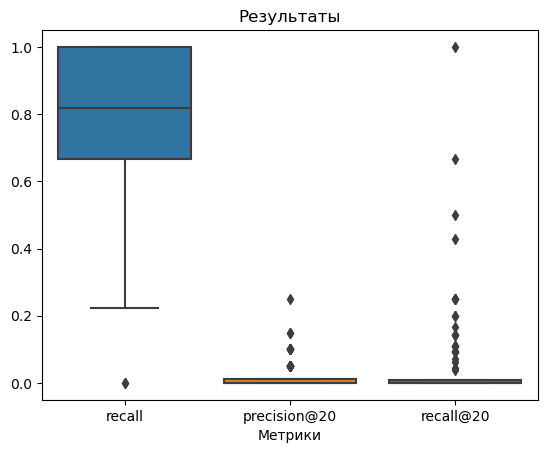

In [ ]:
sns.boxplot(data=pd.DataFrame(res_nn))
plt.xlabel('Метрики')
plt.ylabel('')
plt.title('Результаты')
plt.show()

In [ ]:
parameters  = {}
precisions_ = []
recalls_ = []
recalls_at_20_ = []

In [ ]:
for iter_ in [1000]:
    for depth in [10]:
        for lr in [0.001]:
            for user_id in notebook.tqdm(users):
                train_rank, retrivial_result = RecoveryRec(train_f, test, user_id, top_items, n, 5, num_emb, nn)

                bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())

                target = train_rank['purchaise']
                features = train_rank.drop(['item_id', 'user_id', 'purchaise'], axis=1)

                group_id_train = [0]*target.shape[0]

                # Загрузка данных
                train_data = cb.Pool(data=features, label=target, group_id=group_id_train)
                test_data = cb.Pool(data=retrivial_result)

                parameters['iterations'] = iter_
                parameters['depth'] = depth
                parameters['learning_rate'] = lr

                params = {'iterations': iter_,
                          'custom_metric': ['NDCG'],
                          'verbose': True,
                          'random_seed': RANDOM_STATE,
                          'loss_function' : 'YetiRank',
                          'depth' : depth,
                          'learning_rate' : lr
                }

                model = cb.CatBoost(params)
                model.fit(train_data, verbose=False)
                predictions = model.predict(test_data)

                retrivial_result['rank'] = predictions
                retrivial_result.sort_values(by='rank', inplace=True, ascending=False)

                relevant_recommendations = list(retrivial_result['item_id'].unique())

                precisions_.append(precision_at_k(relevant_recommendations[:20], bought_test))
                recalls_.append(recall_at_k(relevant_recommendations, bought_test))
                recalls_at_20_.append(recall_at_k(relevant_recommendations[:20], bought_test))
            print(parameters)
            print(f'precision@20: {np.mean(precisions_)}')
            print(f'recall@20: {np.mean(recalls_at_20_)}')
            print(f'recall: {np.mean(recalls_)}')
            print(features.shape[0])

In [ ]:
parameters  = {}
precisions_cb = []
recalls_cb = []
recalls_at_20_cb = []

In [ ]:
parameters = {}
for iter_ in [1000]:
    for depth in [7]:
        for lr in [0.001]:
            for user_id in notebook.tqdm(users):
                parameters['depth'] = depth
                parameters['iter_'] = iter_
                train_rank, retrivial_result = Recovery(train_f, test, user_id, top_items, n, k_recovery, num_emb)

                bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())

                target = train_rank['purchaise']
                features = train_rank.drop(['item_id', 'user_id', 'purchaise'], axis=1)

                group_id_train = [0]*target.shape[0]

                # Загрузка данных
                train_data = cb.Pool(data=features, label=target, group_id=group_id_train)
                test_data = cb.Pool(data=retrivial_result)


                params = {'iterations': iter_,
                          'custom_metric': ['NDCG'],
                          'verbose': True,
                          'random_seed': RANDOM_STATE,
                          'loss_function' : 'YetiRank',
                          'depth' : depth,
                          'learning_rate' : lr
                }

                model = cb.CatBoost(params)
                model.fit(train_data, verbose=False)
                predictions = model.predict(test_data)

                retrivial_result['rank'] = predictions
                retrivial_result.sort_values(by='rank', inplace=True, ascending=False)

                relevant_recommendations = list(retrivial_result['item_id'].unique())
                precisions_cb.append(precision_at_k(relevant_recommendations[:20], bought_test))
                recalls_cb.append(recall_at_k(relevant_recommendations, bought_test))
                recalls_at_20_cb.append(recall_at_k(relevant_recommendations[:20], bought_test))

            print(f'precision@20: {np.mean(precisions_cb)}')
            print(f'recall@20: {np.mean(recalls_at_20_cb)}')
            print(f'recall: {np.mean(recalls_cb)}')
            print(features.shape[0], parameters)

  0%|          | 0/100 [00:00<?, ?it/s]

precision@20: 0.015500000000000003
recall@20: 0.044491513116513115
recall: 0.79248254985755
8 {'depth': 7, 'iter_': 1000}


In [ ]:
res_cb = {'recall': recalls_cb, 'precision@20': precisions_cb, 'recall@20': recalls_at_20_cb}

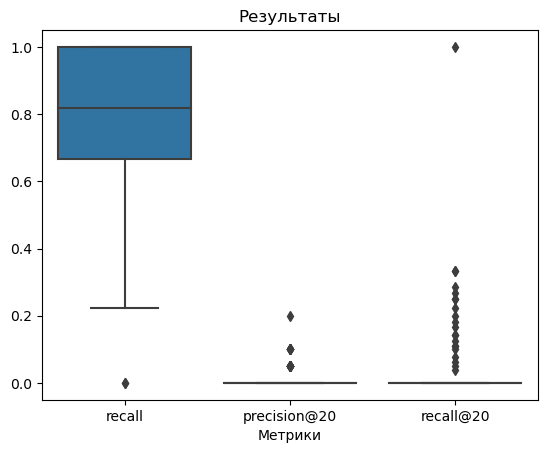

In [ ]:
sns.boxplot(data=pd.DataFrame(res_cb))
plt.xlabel('Метрики')
plt.ylabel('')
plt.title('Результаты')
plt.show()

In [ ]:
parameters = {}
for lambd in [0.001]:
    for lr in [0.001]:
        precisions = []
        for user_id in notebook.tqdm(users):
            parameters['lambda'] = lambd
            parameters['larning rate'] = lr
            train_rank, retrivial_result = Recovery(train_f, test, user_id, top_items, n, k_recovery, num_emb)

            bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())

            target = train_rank['purchaise']
            features = train_rank.drop(['item_id', 'user_id', 'purchaise'], axis=1)
            dump_svmlight_file(features, target, 'libsvm_train_rank.txt')
            param = {'task':'reg', 'lr': lr, 'lambda': lambd, 'metric':'acc'}

            ffm_model = xl.create_ffm()
            ffm_model.setTrain("libsvm_train_rank.txt")


            ffm_model.fit(param, "ffm_out.out")
            ffm_model.setSign()
            retrivial_result_test = retrivial_result.drop(['user_id', 'item_id'], axis=1)
            dump_svmlight_file(retrivial_result_test, np.zeros(retrivial_result_test.shape[0]), 'libsvm_test_rank.txt')
            ffm_model.setTest("libsvm_test_rank.txt")
            ffm_model.predict("ffm_out.out", 'output_rank.txt')
            rank = pd.read_csv('output_rank.txt')
            retrivial_result.reset_index(inplace=True, drop=True)
            retrivial_result['rank'] = rank
            retrivial_result.reset_index(inplace=True, drop=True)
            relevant_recommendations = retrivial_result.sort_values(by='rank', ascending=False)

            precisions.append(precision_at_k(relevant_recommendations[:20], bought_test))
        print(np.mean(precisions))
        print(parameters)

Другая модель BM25 для ранжирования:

In [ ]:
users = random.sample(users_tt, 100)
parameters  = {}
precisions_bm = []
recalls_bm = []
recalls_at_20_bm = []

In [ ]:
grouped_train = train_.drop(['order_ts'], axis=1).groupby('user_id')['item_id'].agg(lambda x: list(map(str, x)))
for user_id in notebook.tqdm(users):

    query = list(map(str, grouped_train.loc[user_id]))
    grouped_train_1 = grouped_train.drop(user_id, axis=0)

    query = list(set(query))

    corpus = np.array(grouped_train_1.values)
    bm25 = BM25Okapi(corpus)
    doc_scores = bm25.get_scores(query)

    sc = pd.DataFrame(data=doc_scores, index=grouped_train_1.index, columns=['scores'])
    sc_sort = sc.sort_values(by='scores', ascending=False)
    users_relevant = sc_sort[sc_sort['scores'] > 0].index

    merged_list = list(chain.from_iterable(grouped_train_1[users_relevant].values))
    rec = list(map(int, pd.Series(merged_list).unique()))
    bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())
    query_int = list(map(int, query))
    rec_new = [x for x in rec if x not in query_int]

    precisions_bm.append(precision_at_k(rec_new[:20], bought_test))
    recalls_bm.append(recall_at_k(rec_new, bought_test))
    recalls_at_20_bm.append(recall_at_k(rec_new[:20], bought_test))

print(f'precision@20: {np.mean(precisions_bm)}')
print(f'recall@20: {np.mean(recalls_at_20_bm)}')
print(f'recall: {np.mean(recalls_bm)}')

  0%|          | 0/100 [00:00<?, ?it/s]

precision@20: 0.018000000000000002
recall@20: 0.043092564154635096
recall: 0.813008910876817


In [ ]:
res_bm = {'recall': recalls_bm, 'precision@20': precisions_bm, 'recall@20': recalls_at_20_bm}

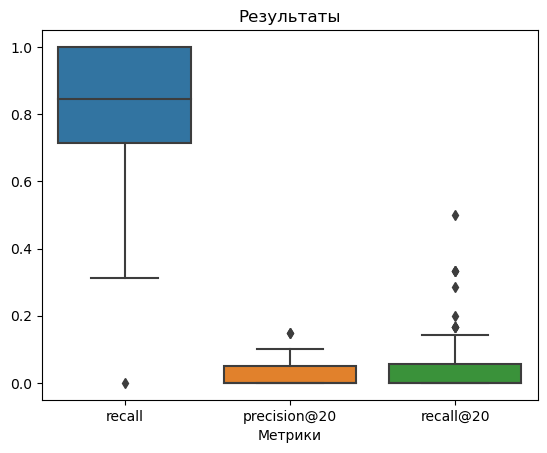

In [ ]:
sns.boxplot(data=pd.DataFrame(res_bm))
plt.xlabel('Метрики')
plt.ylabel('')
plt.title('Результаты')
plt.show()

Итог:
- при использовании только faiss и catboost - результат лучше других
- при использовании двойного извлечения результат не меняется (и даже иногда хуже)
- при использовании NN для тренирововочной выборки catboost после faiss и до ранжирования - лучший результат
- при использовании BM25 для извлеченной выборки - результат хуже
- при использовании BM25 для всей выборки - результат незначительно хуже

Попробуем примеить BM25 для ранжирования для наших приззнаков:

In [ ]:
for user_id in notebook.tqdm(users):

    train_rank, retrivial_result = Recovery(train_f, test, user_id, top_items, n, k_recovery, num_emb)
    grouped_train = retrivial_result.agg(lambda x: list(map(str, x)))

    query = list(map(str, train_f.iloc[user_id]))
    query = list(set(query))

    corpus = np.array(grouped_train.values)
    bm25 = BM25Okapi(corpus)
    doc_scores = bm25.get_scores(query)

    sc = pd.DataFrame(data=doc_scores, index=grouped_train.index, columns=['scores'])
    sc_sort = sc.sort_values(by='scores', ascending=False)
    users_relevant = sc_sort[sc_sort['scores'] > 0]

    recommendations = retrivial_result.join(users_relevant, how='right')['item_id']
    bought_test = list(test[test['user_id'] == user_id]['item_id'].unique())
    recommendations = list(recommendations.unique())

    precisions_mix.append(precision_at_k(recommendations[:20], bought_test))
    recalls_mix.append(recall_at_k(recommendations, bought_test))
    recalls_at_20_mix.append(recall_at_k(recommendations[:20], bought_test))

print(f'precision@20: {np.mean(precisions_mix)}')
print(f'recall@20: {np.mean(recalls_at_20_mix)}')
print(f'recall: {np.mean(recalls_mix)}')

  0%|          | 0/100 [00:00<?, ?it/s]

precision@20: 0.012980769230769231
recall@20: 0.02842460830232569
recall: 0.752162757023092


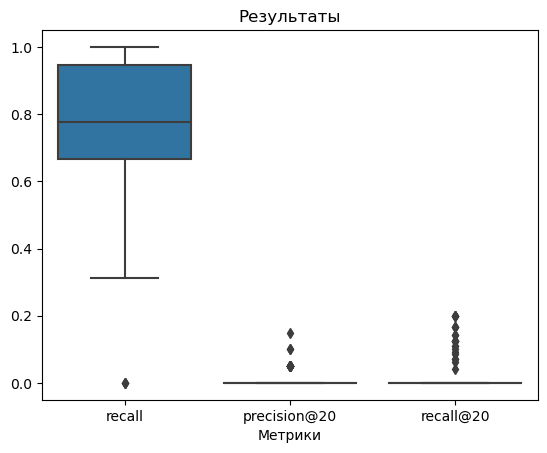

In [ ]:
res_mix = {'recall': recalls_mix, 'precision@20': precisions_mix, 'recall@20': recalls_at_20_mix}

sns.boxplot(data=pd.DataFrame(res_mix))
plt.xlabel('Метрики')
plt.ylabel('')
plt.title('Результаты')
plt.show()

In [ ]:
print(f'Coverage xlearn : {coverage_xl:.2f}')
print(f'Coverage catboost : {coverage_cb:.2f}')

Coverage xlearn : 30.49
Coverage catboost : 22.92


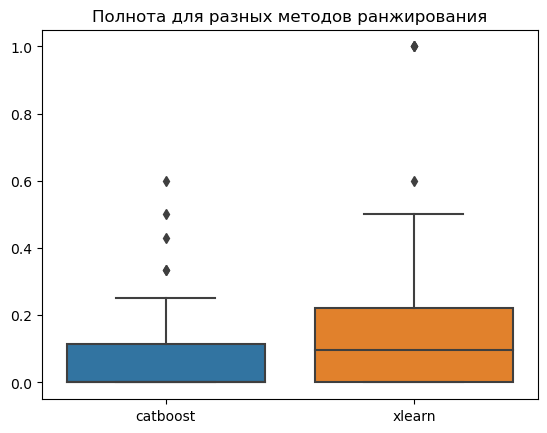

In [ ]:
sns.boxplot(data=pd.DataFrame(df_recalls))
plt.title('Полнота для разных методов ранжирования')
plt.show()

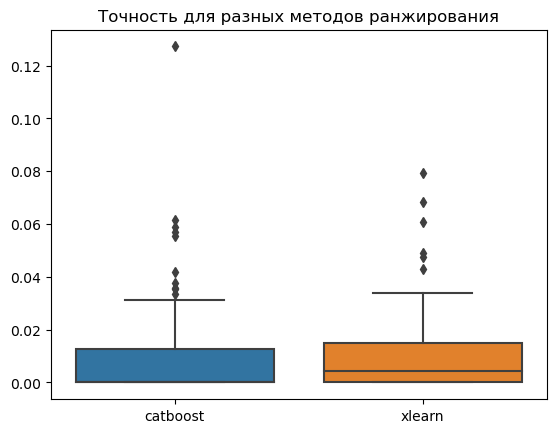

In [ ]:
sns.boxplot(data=pd.DataFrame(df_precisions))
plt.title('Точность для разных методов ранжирования')
plt.show()

Результаты:
- в среднем себя лучше показывает **xlearn**
- для отдельный элементов гораздо лучшие точность у **catboost**

## Кросс-валидация

In [ ]:
users = random.sample(users_tt, 50)

In [ ]:
k = 200

In [ ]:
# parameters = {}
# scores = {}
# max_precision = 0

# for n in [2_000_000, 4_000_000, 6_000_000]:
#     for th in [-5, 0, 5]:
#         vi = 10
#         vu = 5
#         nn = 25
#         k_recovery = 15
#         all_rec, recalls, precisions = RRN_Cb(train_, test, users, n, nn, th, 100)
#         parameters['batch_size'] = n
#         parameters['threshold'] = th

#         train_ = train_.reset_index(drop=True)

#         scores['recall_mean'] = np.mean(recalls)
#         scores['precision_mean'] = np.mean(precisions)
#         scores['recall_max'] = max(recalls)
#         scores['precision_max'] = max(precisions)

#         scores['coverage'] = len(set(all_rec))/len(set(data['item_id'].unique()))*100

#         print(f'Параметры: {parameters}')
#         print(f'Result {scores}')
#         print('_'*30)

#         if scores['precision_mean'] > max_precision:
#             best_score = scores
#             best_params = parameters

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

При подборе гиперпараметров при учете всех рекомендаций получились средние **recall ~0.2, precision ~0.015**

Оптимальные параметры: nn = 25, k = 15, batch_size = 4000000, threshold для catboost: -5

Лучшие параметры 'batch_size': 4000000, 'threshold': -5

### Оценка модели (здесь на тестовой выборке)

Для нашего пользователя:

<div style='color:red;'>Учесть количество покупок в тестовой выборке<div>

In [ ]:
n = 4_000_000 # размер батча
vi = 10 # вектор эмбеддингов айтемов
vu = 5 # вектор эмбеддингов юзеров
nn = 25 # число ближайших соседей
k_recovery = 15 # число извлеченных объектов

users = random.sample(users_tt, 500)

all_rec_xl, recalls_xl, precisions_xl = RRN_Xlearn(train_, test, users, 200)

  0%|          | 0/500 [00:00<?, ?it/s]

NameError: name 'all_rec' is not defined

In [ ]:
coverage_xl = len(set(all_rec_xl))/len(set(data['item_id'].unique()))*100

In [ ]:
print(f'Покрытие : {coverage_xl:.2f}')

Покрытие : 50.69


In [ ]:
print(f'Средняя точность : {np.mean(precisions_xl):.2f}')
print(f'Средняя полнота : {np.mean(recalls_xl):.2f}')

Средняя точность : 0.01
Средняя полнота : 0.14


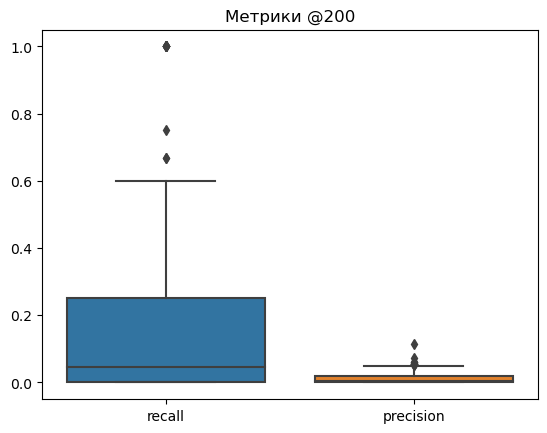

In [ ]:
sns.boxplot(data=pd.DataFrame({'recall': recalls_xl, 'precision': precisions_xl}))
plt.title('Метрики @200')
plt.show()

In [ ]:
th = -5 # шаг для catboost
n = 4_000_000 # размер батча
vi = 10 # вектор эмбеддингов айтемов
vu = 5 # вектор эмбеддингов юзеров
nn = 25 # число ближайших соседей
k_recovery = 15 # число извлеченных объектов
users = random.sample(users_tt, 500)
all_rec_cb, recalls_cb, precisions_cb = RRN_Cb(train_, test, users, n, nn, th, 200)

coverage = len(set(all_rec_cb))/len(set(data['item_id'].unique()))*100

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
coverage_cb = len(set(all_rec_cb))/len(set(data['item_id'].unique()))*100

In [ ]:
print(f'Покрытие : {coverage_cb:.2f}')

Покрытие : 44.71


In [ ]:
print(f'Средняя точность : {np.mean(precisions_cb):.2f}')
print(f'Средняя полнота : {np.mean(recalls_cb):.2f}')

Средняя точность : 0.01
Средняя полнота : 0.11


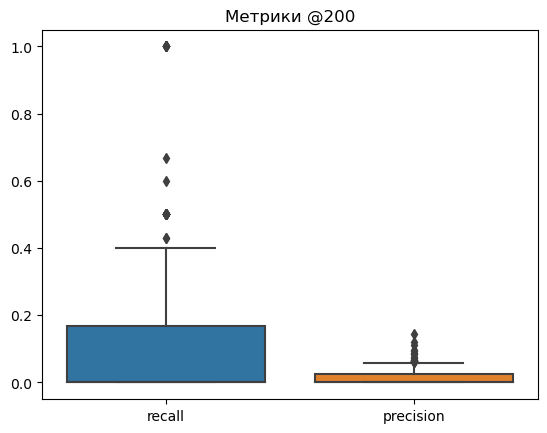

In [ ]:
sns.boxplot(data=pd.DataFrame({'recall': recalls_cb, 'precision': precisions_cb}))
plt.title('Метрики @200')
plt.show()

### Структура пайплайна

**1. Отчиска данных от выбросов критерием Граббса** <br>
Параметры: `p1..p5` - коэффициенты для выбросов <br>

**2. Формирование эмбеддингов для юзеров и айтемов** <br>
Параметры: `mc_users`, `mc_items` - минимальное количество юзеров и айтемов в датасета для включения их в эмбеддинги; <br>
`vector_users`, `vector_items` - величина векторов эмбеддингов <br>

**3. Добавление признаков** <br>
Формирование признаков для даты покупки, а именно время и месяц в трионометрическом представлении для учета возможной цикличности - `FeaturesAdd()` <br>

**4. Извлечение** <br>
Извлечение происходит хешированием (для быстрой работы) батчами из исходного датасаета. Происходит формирование эмбеддингов, похожих на эмбеддинг нужного юзера. Осуществляем с помощью библиотеки `faiss` - `Recovery()` <br>
Параметры: `n` - величина батча, `k` - число извлеченных объектов <br>
Если m - число товаров, купленных пользователем, то всего извлечено эмбеддингов будет $ i*m*k $, где i - количество иттераций (сколько батчей помещается в тренировочной выборке) <br>

**5. Ранжирование** <br>
Учет признаков дат и эмбеддингов для предварительного ранжирования <br>
Коэффициенты дистанций для каждой из релевантных рекомендаций, а затем ранжирование с таргетом - расстоянием.
Параметры могут быть разные в зависимости от модели.

**6. Поиск наиболее релевантных рекомендаций** <br>
На основе метода поиска ближайших соседей ищем наиболее релеванстные рекомендации <br>

**7. Оценка модели** <br>
Оценка на 1000 пользователей

💡Проверить важность признаков

Источники:
1. <a href='https://habr.com/ru/companies/otus/articles/732842/'> Метрики </a>